In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jul 14 13:00:24 2018

@author: guidosidoni
"""

import pandas as pd	
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import metrics

training = pd.read_csv('/Users/guidosidoni/Documents/NEU/Misselanea/HousePricePrediction/train.csv')

training.columns

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Index([u'id', u'titulo', u'descripcion', u'tipodepropiedad', u'direccion',
       u'ciudad', u'provincia', u'antiguedad', u'habitaciones', u'garages',
       u'banos', u'metroscubiertos', u'metrostotales', u'idzona', u'lat',
       u'lng', u'fecha', u'gimnasio', u'usosmultiples', u'piscina',
       u'escuelascercanas', u'centroscomercialescercanos', u'precio'],
      dtype='object')

In [2]:
#PLOTING THE OUTPUT

def plotResults():
    acc = history.history['mean_squared_logarithmic_error']
    val_acc = history.history['val_mean_squared_logarithmic_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Valiudation acc')     
    plt.title('Training and validation accuracy')   
    plt.legend() 

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [4]:
########## CREATION OF NEW VARIABLES #################
training['precioM2'] = training.precio / training.metrostotales
training['FechaD'] = pd.to_datetime(training.fecha, format="%Y-%m-%d")

#add year, month

training.describe()

##### Looking for NA #######
training.isnull().values.any()
training.isnull().any()

training.titulo
training.descripcion
training.tipodepropiedad
training['tipodepropiedad'] = training['tipodepropiedad'].fillna(' ')

training.direccion
training.ciudad
crosstabCiudad = pd.crosstab(training.ciudad,1)
crosstabCiudad = crosstabCiudad.rename(columns={1:'count'})
crosstabCiudad.sort_values('count',ascending=False)
training['ciudad'] = training['ciudad'].fillna(' ')

training.provincia
pd.crosstab(training.provincia, 1).rename(columns={1:'count'}).sort_values('count', ascending=False)
training['provincia'] = training['provincia'].fillna(' ')

training.antiguedad
pd.crosstab(training.habitaciones, 1)
training['habitaciones'] = training['habitaciones'].fillna(0)

training['gimnasio'] = training['gimnasio'].fillna(0)
training['usosmultiples'] = training['usosmultiples'].fillna(0)
training['garages'] = training['garages'].fillna(0)
training['banos'] = training['banos'].fillna(0)
training['metroscubiertos'] = training['metroscubiertos'].fillna(0)
training['metrostotales'] = training['metrostotales'].fillna(0)




In [13]:
training['yearmonth'] = training['FechaD'].dt.year * 100 + training['FechaD'].dt.month
training['yearmonth'].isnull().any()

False

In [5]:
training.isnull().any()

id                            False
titulo                         True
descripcion                    True
tipodepropiedad               False
direccion                      True
ciudad                        False
provincia                     False
antiguedad                     True
habitaciones                  False
garages                       False
banos                         False
metroscubiertos               False
metrostotales                 False
idzona                         True
lat                            True
lng                            True
fecha                         False
gimnasio                      False
usosmultiples                 False
piscina                       False
escuelascercanas              False
centroscomercialescercanos    False
precio                        False
precioM2                       True
FechaD                        False
dtype: bool

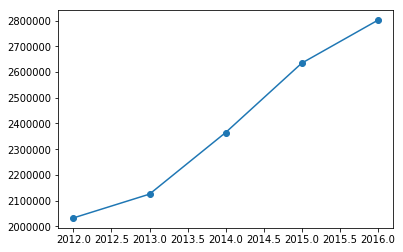

In [7]:
##ploting price by year
year = training.groupby(training.FechaD.dt.year )
priceYear = (year.agg({'precio':'mean', 'precioM2':'mean'}) 
    .rename(columns={'precio':'mean_precio', 'precioM2':'mean_precioM2'}))

plt.plot(priceYear.index, priceYear.mean_precio, '-o')
plt.plot(priceYear.index, priceYear.mean_precioM2, '-o')

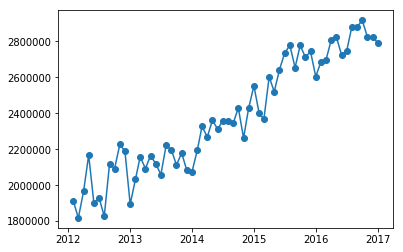

In [8]:
#ploting price by month and year
monthyear = training.set_index('FechaD')
monthyear = monthyear.resample('M').mean()
plt.plot(monthyear.index, monthyear.precio, '-o')
plt.plot(monthyear.index, monthyear.precioM2, '-o')


In [14]:
############################################

####One hot encoding
trainingShort = training[['tipodepropiedad','provincia','precio','yearmonth','habitaciones','garages','banos',
                       'metroscubiertos','metrostotales', 'gimnasio','usosmultiples','piscina',
                       'escuelascercanas','centroscomercialescercanos']]


trainingShort2 = pd.concat([trainingShort.iloc[:,2:], 
                         pd.get_dummies(trainingShort.provincia), 
                         pd.get_dummies(training.tipodepropiedad)
                         ], axis=1)

trainingShort2.columns

##### Shuffle data
trainingShort2 = np.array(trainingShort2 )
np.random.shuffle(trainingShort2)
trainingShort2
trainingShort2.shape
##### Standarized Values

train_data = trainingShort2[:,1:]
train_target = trainingShort2[:,0]

mean = train_data.mean(axis=0)
mean.shape
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

#test_data -= mean
#test_data /= std

In [11]:
######### MODEL SETING ##########

def build_model(train_data):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=[metrics.mean_squared_logarithmic_error])
    return model


In [12]:
train_data, val_data, train_targets, val_targets = train_test_split(train_data, train_target, random_state = 222, test_size=0.2)

model = build_model(train_data)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4416      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#we save the history of the fiting.
history = model.fit(train_data, 
                    train_targets, 
                    validation_data=(val_data, val_targets),
                    epochs=30, batch_size=1, 
                    verbose=1)


plotResults()

Train on 192000 samples, validate on 48000 samples
Epoch 1/30
192000/192000 [==============================] - 197s 1ms/step - loss: 3900727806342.7012 - mean_squared_logarithmic_error: 6.5611 - val_loss: 3276972775093.0625 - val_mean_squared_logarithmic_error: 2.932260051425.4829 - mean_s - ETA: 49s - loss: 40981368000 - ETA: 2s - loss: 3 - ETA: 1s - loss: 3902331
Epoch 2/30
192000/192000 [==============================] - 194s 1ms/step - loss: 3024105459972.6348 - mean_squared_logarithmic_error: 1.8654 - val_loss: 2786152424865.4292 - val_mean_squared_logarithmic_error: 1.06941:18 - loss: 3144656719437 - ETA: 1:14 - loss: 3136443629705.4556  - ETA: 1:14 - loss: 3138979600700.6460 - mean_squared_logarithmic_error: 2.24 - ETA: 1:14 - loss: 3138608945011.7646 - mean_squared_logarithmic_err - ETA: 1:13 - loss: 3136986043937.7856 - mean_squared_logarithmic_e - ETA: 1:13 - loss: 3138439042019.5356 - mean_squared_logarit - - ETA: 1:05 - loss: 3 - ETA: 1:03 - loss: 313516085 - ETA: 47s - los

In [ ]:
#SAVE THE MODEL
model.save('HPP_model1.h5')
